In [1]:
from system import *
from math import floor
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as color

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

plt.rcParams.update({'font.size': 36})
plt.rcParams['font.family'] = 'Liberation Sans'
#plt.rcParams['font.sans-serif'] = ['Liberation']

e_field = zero_field()
b_field = t89(7)
system  = System(e_field, b_field)

Load IGRF coefficients ...


In [2]:
system.load("5000_12Re_1MeV_20pa")

Loaded files containing 916.10 megabytes of information.


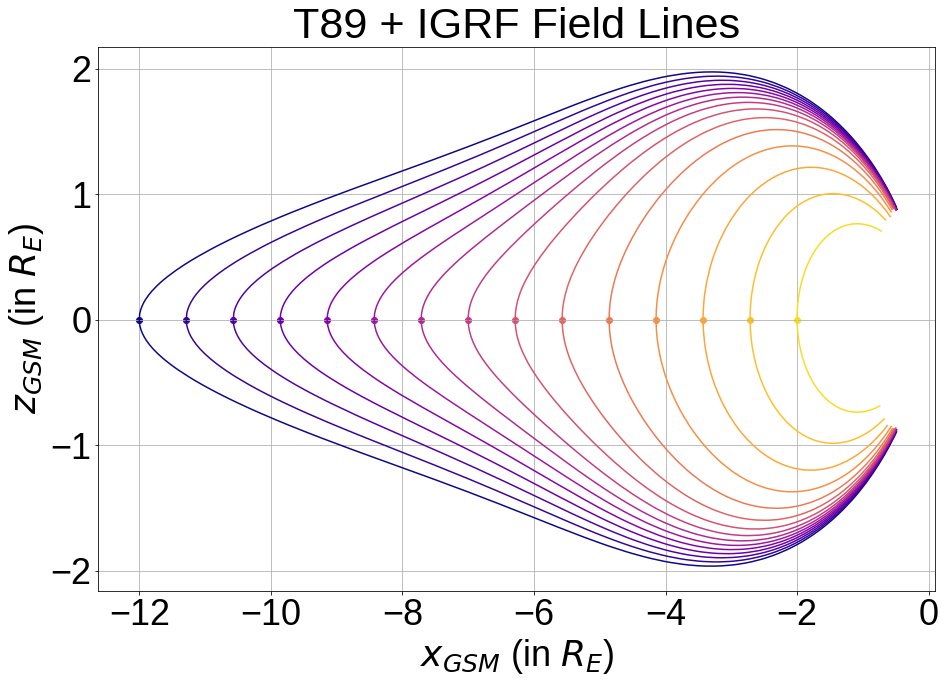

In [3]:
from field_utils import *

plt.figure(figsize=(15, 10))

n = 15
for i, x in enumerate(np.linspace(-12 * Re, -2 * Re, n)):
    rr = field_line(b_field, np.array([x, 0, 0]), 1e-2)
    r_min = field_reversal(b_field, rr)
    
    plt.plot(rr[:, 0] / Re, rr[:, 2] / Re, color=plt.cm.plasma(i / n))
    plt.scatter(r_min[0] / Re, r_min[2] / Re, color=plt.cm.plasma(i / n))
    
plt.grid()
plt.xlabel('$x_{GSM}$ (in $R_E$)')
plt.ylabel('$z_{GSM}$ (in $R_E$)')
plt.title('T89 + IGRF Field Lines')
plt.show()

In [5]:
system.populate_by_eq_pa(500,
                         delta(10),
                         delta(1e6),
                         delta(np.radians(20)),
                         uniform(0, 2*np.pi)
                        )

100%|██████████| 500/500 [00:11<00:00, 44.06it/s] 


In [6]:
system.solve(1, 1e-4)

100%|██████████| 500/500 [00:19<00:00, 25.28it/s]


In [5]:
system.save("5000_12Re_1MeV_20pa")

Saved files containing 916.10 megabytes of information.


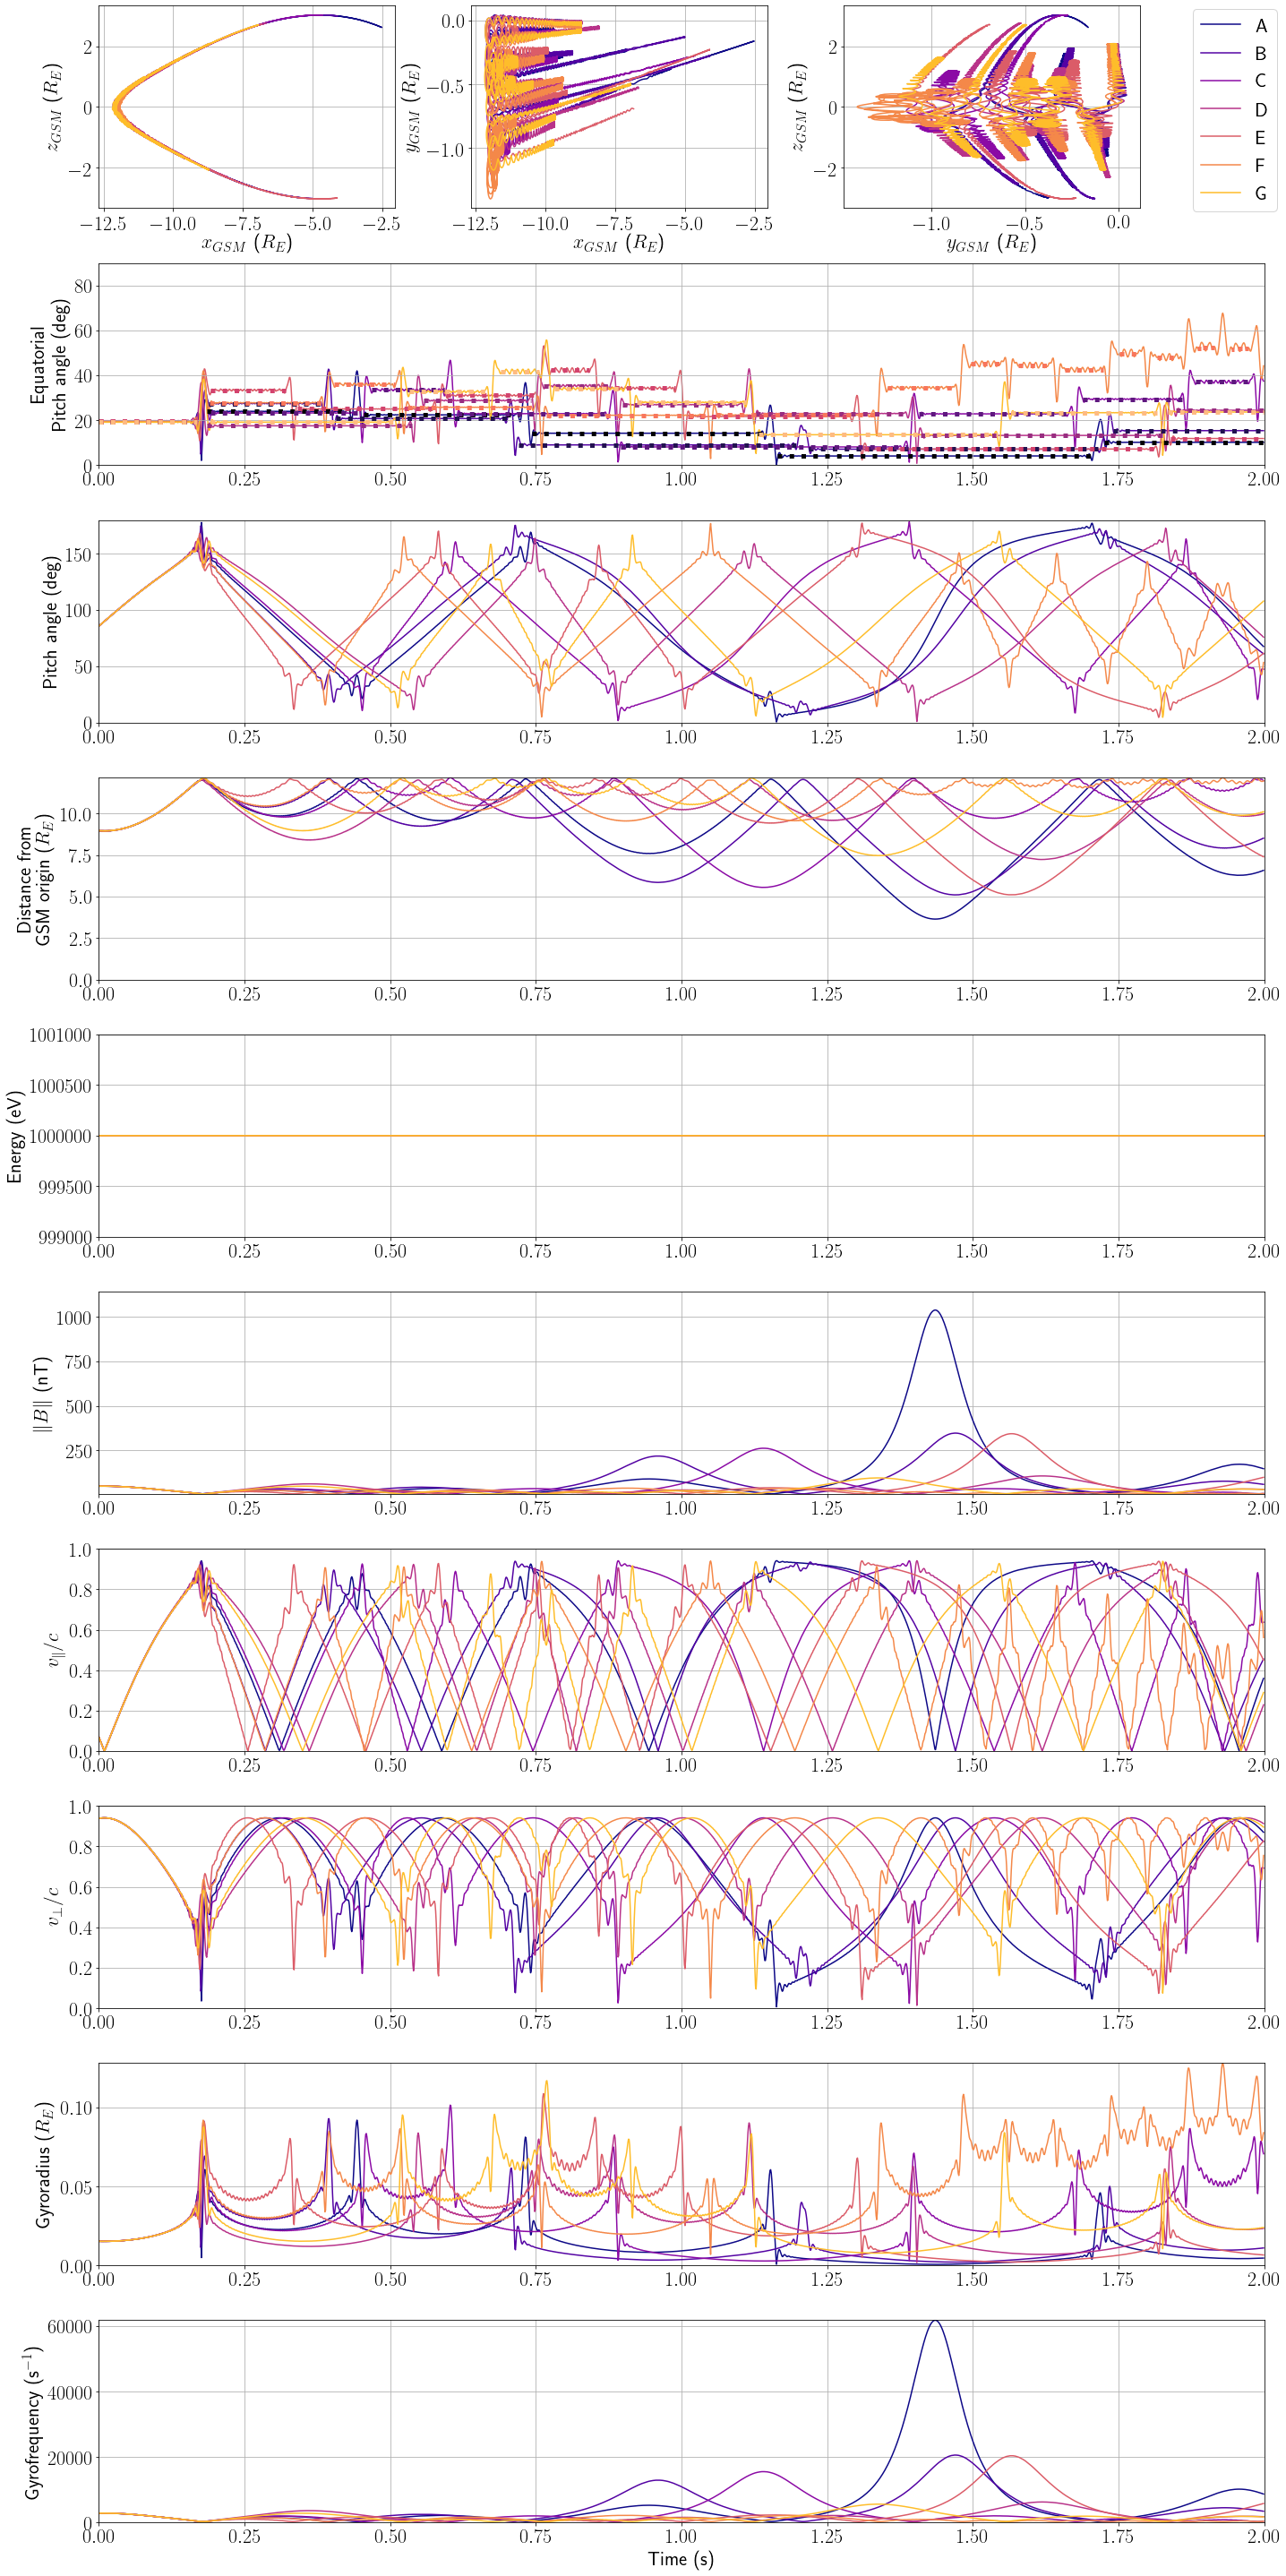

In [18]:
system.plot([523, 2380, 135, 4913, 27, 559, 1332])

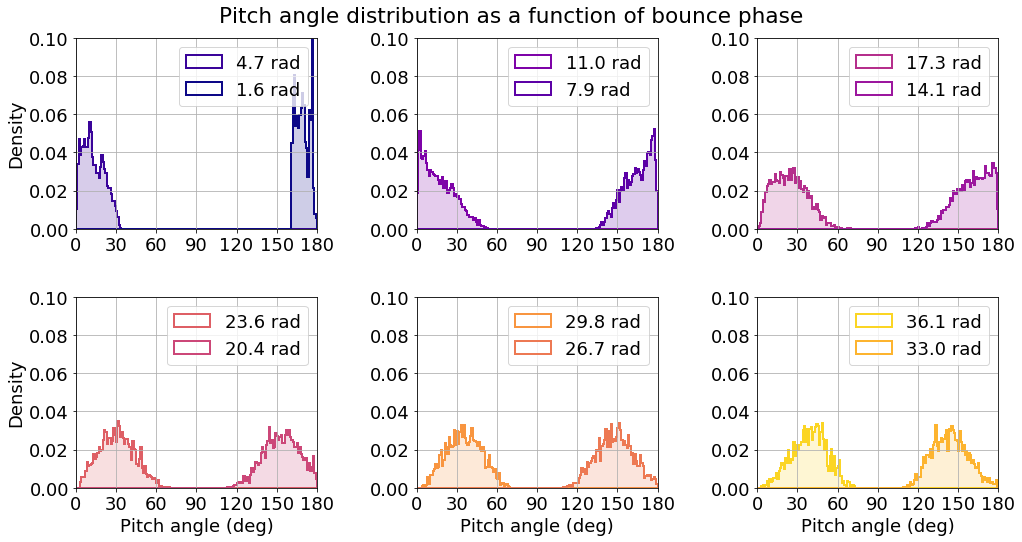

In [3]:
from math import ceil

phase_list = [(2*k + 1) * np.pi / 2 for k in range(12)]
colors = plt.cm.plasma([i / len(phase_list) for i in range(len(phase_list))])
phases = []
fig = plt.figure(figsize=(15, 8))

for phase in phase_list:
    phases.append(get_pas_at_bounce_phase(system.history, phase))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.hist(phases[(2 * i):(2 * i) + 2], bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[(2 * i):(2 * i) + 2], density=True, label=[f'{k:.1f} rad' for k in phase_list[(2 * i):(2 * i) + 2]])
    plt.hist(phases[(2 * i):(2 * i) + 2], bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[(2 * i):(2 * i) + 2], density=True)
    plt.grid()
    plt.xlim([0, 180])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.yticks(np.arange(0, 0.11, 0.02))
    plt.xticks(np.arange(0, 181, 30))
    
    if i % 3 == 0:
        plt.ylabel('Density')
    
    if i > 2:
        plt.xlabel('Pitch angle (deg)')

fig.suptitle('Pitch angle distribution as a function of bounce phase')
plt.tight_layout(pad=2)
plt.show()

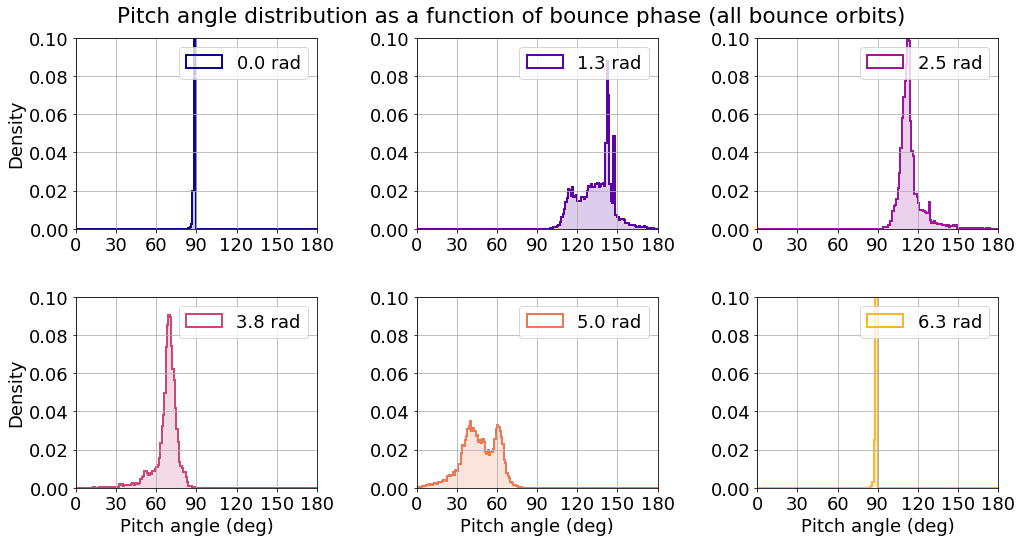

In [4]:
from math import ceil

phase_list = np.linspace(0, 2*np.pi, 6)
colors = plt.cm.plasma([i / len(phase_list) for i in range(len(phase_list))])
phases = []
fig = plt.figure(figsize=(15, 8))

for phase in phase_list:
    phases.append(get_pas_at_bounce_phase_all_t(system.history, phase))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.hist(phases[i], bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'{phase_list[i]:.1f} rad')
    plt.hist(phases[i], bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    plt.grid()
    plt.xlim([0, 180])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.yticks(np.arange(0, 0.11, 0.02))
    plt.xticks(np.arange(0, 181, 30))
    
    if i % 3 == 0:
        plt.ylabel('Density')
    
    if i > 2:
        plt.xlabel('Pitch angle (deg)')

fig.suptitle('Pitch angle distribution as a function of bounce phase (all bounce orbits)')
plt.tight_layout(pad=2)
plt.show()

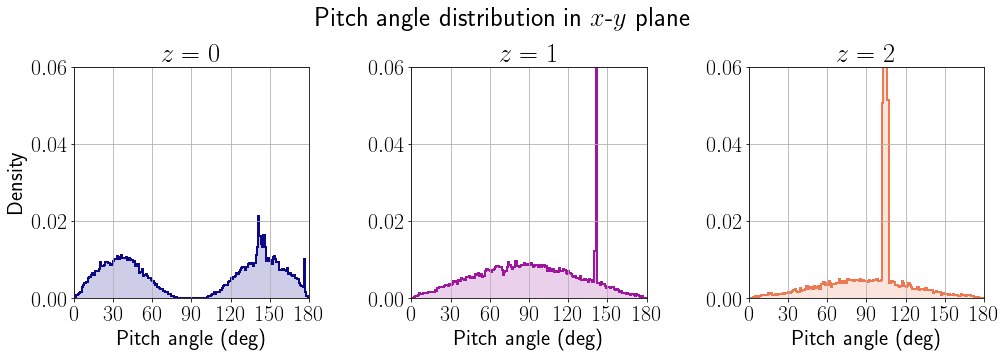

In [21]:
def pitch_angles_in_xy_plane(history, intrinsic, z_gsm):
    num_particles = len(history[:, 0, 0, 0])
    steps = len(history[0, :, 0, 0])
    
    pas = pitch_angle(history)
    history_container = []
    
    for i in range(num_particles):
        centered = history[i, :, 0, 2] / Re - z_gsm
        crossings = np.where(np.diff(np.sign(centered)))[0]
        
        history_container = np.append(history_container, pas[i, crossings].flatten())
        
    return np.array(history_container).flatten()


z_list = [0, 1, 2]
colors = plt.cm.plasma([k / len(z_list) for k in range(len(z_list))])
pas = []
fig = plt.figure(figsize=(15, 5.5))

for z in z_list:
    pas.append(pitch_angles_in_xy_plane(system.history, system.ics[:, 4, 0:2], z))
    
for i, pa in enumerate(pas):
    plt.subplot(1, 3, i + 1)
    plt.hist(pa, bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'$z = {z_list[i]}$')
    plt.hist(pa, bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    
    plt.xlabel('Pitch angle (deg)')
    plt.grid()
    plt.xlim([0, 180])
    plt.xticks(np.arange(0, 181, 30))
    plt.ylim([0, 0.06])
    plt.yticks(np.arange(0, 0.07, 0.02))
    plt.title(f'$z = {z_list[i]}$')
    
    if i == 0:
        plt.ylabel('Density')       

fig.suptitle('Pitch angle distribution in $x$-$y$ plane')
plt.tight_layout(pad=2)
plt.show()

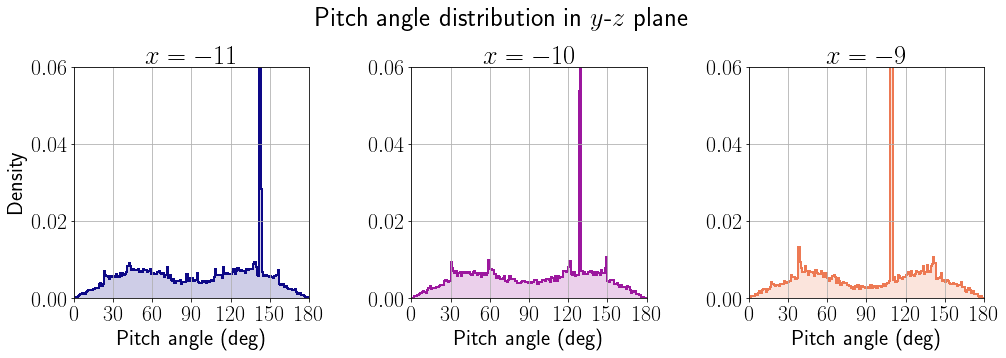

In [22]:
def pitch_angles_in_yz_plane(history, intrinsic, x_gsm):
    num_particles = len(history[:, 0, 0, 0])
    steps = len(history[0, :, 0, 0])
    
    pas = pitch_angle(history)
    history_container = []
    
    for i in range(num_particles):
        centered = history[i, :, 0, 0] / Re - x_gsm
        crossings = np.where(np.diff(np.sign(centered)))[0]
        
        history_container = np.append(history_container, pas[i, crossings].flatten())
        
    return np.array(history_container).flatten()


x_list = [-11, -10, -9]
colors = plt.cm.plasma([k / len(x_list) for k in range(len(x_list))])
pas = []
fig = plt.figure(figsize=(15, 5.5))

for x in x_list:
    pas.append(pitch_angles_in_yz_plane(system.history, system.ics[:, 4, 0:2], x))
    
for i, pa in enumerate(pas):
    plt.subplot(1, 3, i + 1)
    plt.hist(pa, bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'$x = {x_list[i]}$')
    plt.hist(pa, bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    
    plt.xlabel('Pitch angle (deg)')
    plt.grid()
    plt.xlim([0, 180])
    plt.xticks(np.arange(0, 181, 30))
    plt.ylim([0, 0.06])
    plt.yticks(np.arange(0, 0.07, 0.02))
    plt.title(f'$x = {x_list[i]}$')
    
    if i == 0:
        plt.ylabel('Density')       

fig.suptitle('Pitch angle distribution in $y$-$z$ plane')
plt.tight_layout(pad=2)
plt.show()

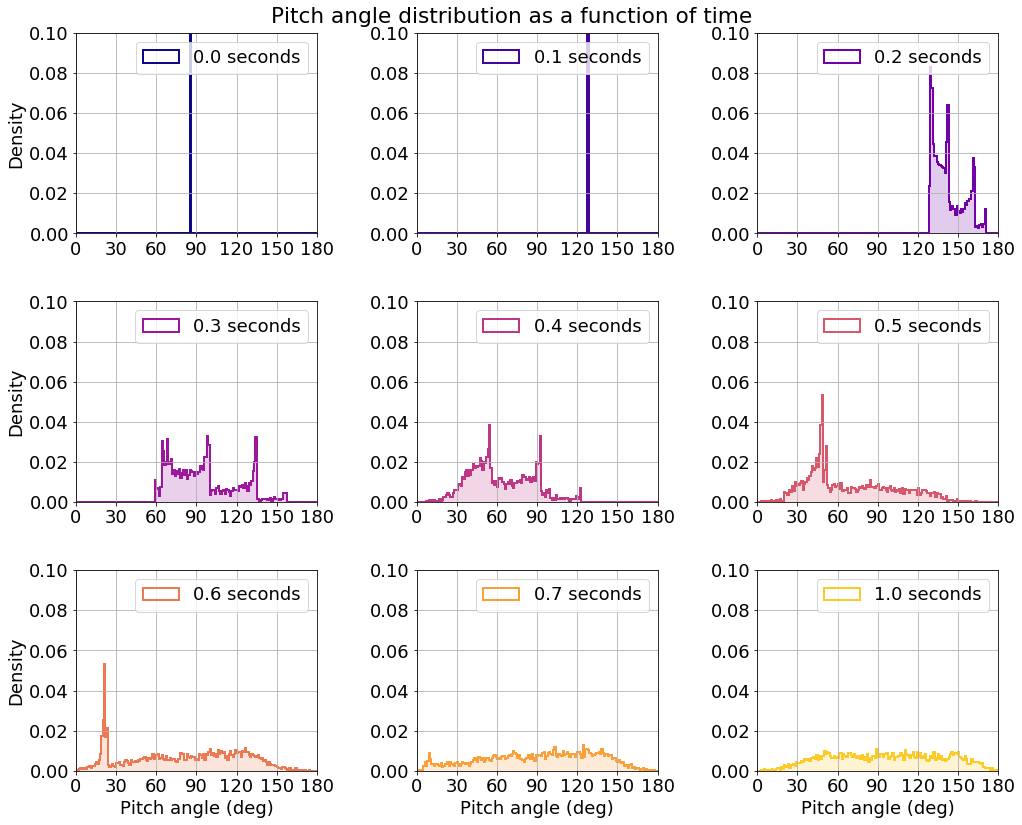

In [5]:
pas = pitch_angle(system.history)

times = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0]
colors = plt.cm.plasma([k / len(times) for k in range(len(times))])

fig = plt.figure(figsize=(15, 12))

for i, t in enumerate(times):
    plt.subplot(3, 3, i + 1)
    plt.hist(pas[:, int(t / 1e-3)], bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'{t} seconds')
    plt.hist(pas[:, int(t / 1e-3)], bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    plt.grid()
    plt.xlim([0, 180])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.yticks(np.arange(0, 0.11, 0.02))
    plt.xticks(np.arange(0, 181, 30))
    
    if i % 3 == 0:
        plt.ylabel('Density')
    
    if i > 5:
        plt.xlabel('Pitch angle (deg)')

fig.suptitle('Pitch angle distribution as a function of time')
plt.tight_layout(pad=2)
plt.show()

In [48]:
eq_pas_extracted = get_eq_pas(b_field, system.history, system.ics[:, 4, 0:2])

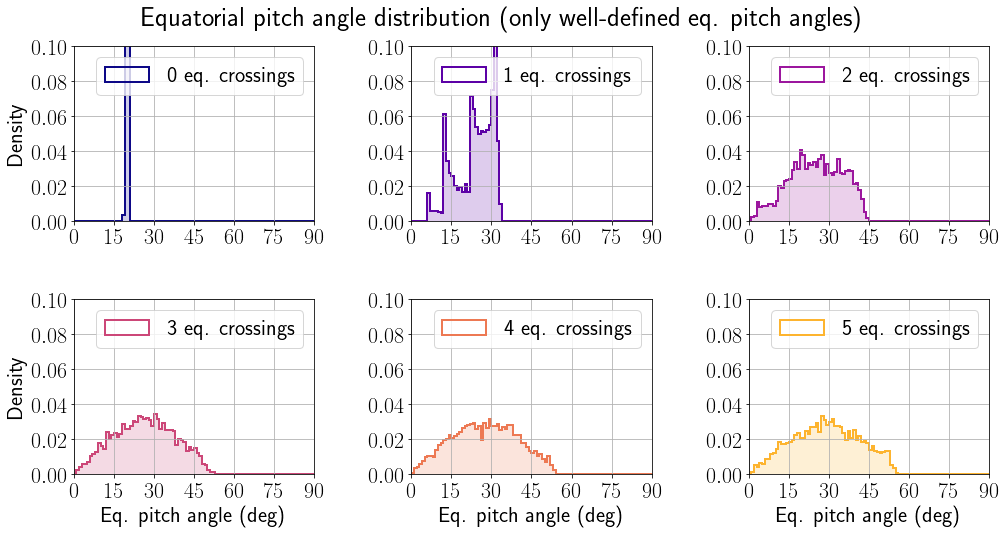

In [91]:
xings = [0, 1, 2, 3, 4, 5]
colors = plt.cm.plasma([k / len(xings) for k in range(len(xings))])

fig = plt.figure(figsize=(15, 8))

for i, n in enumerate(xings):
    plt.subplot(2, 3, i + 1)
    plt.hist(eq_pas_extracted[np.where(eq_pas_extracted[:, n, 0] != -1)[0], n, 0], bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'{n} eq. crossings')
    plt.hist(eq_pas_extracted[np.where(eq_pas_extracted[:, n, 0] != -1)[0], n, 0], bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    plt.grid()
    plt.xlim([0, 90])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.yticks(np.arange(0, 0.11, 0.02))
    plt.xticks(np.arange(0, 91, 15))
    
    if i % 3 == 0:
        plt.ylabel('Density')
    
    if i > 2:
        plt.xlabel('Eq. pitch angle (deg)')

fig.suptitle('Equatorial pitch angle distribution (only well-defined eq. pitch angles)')
plt.tight_layout(pad=2)
plt.show()

In [60]:
eq_pas_instantaneous = eq_pitch_angle_from_moment(system.history, system.ics[:, 4, 0:2])

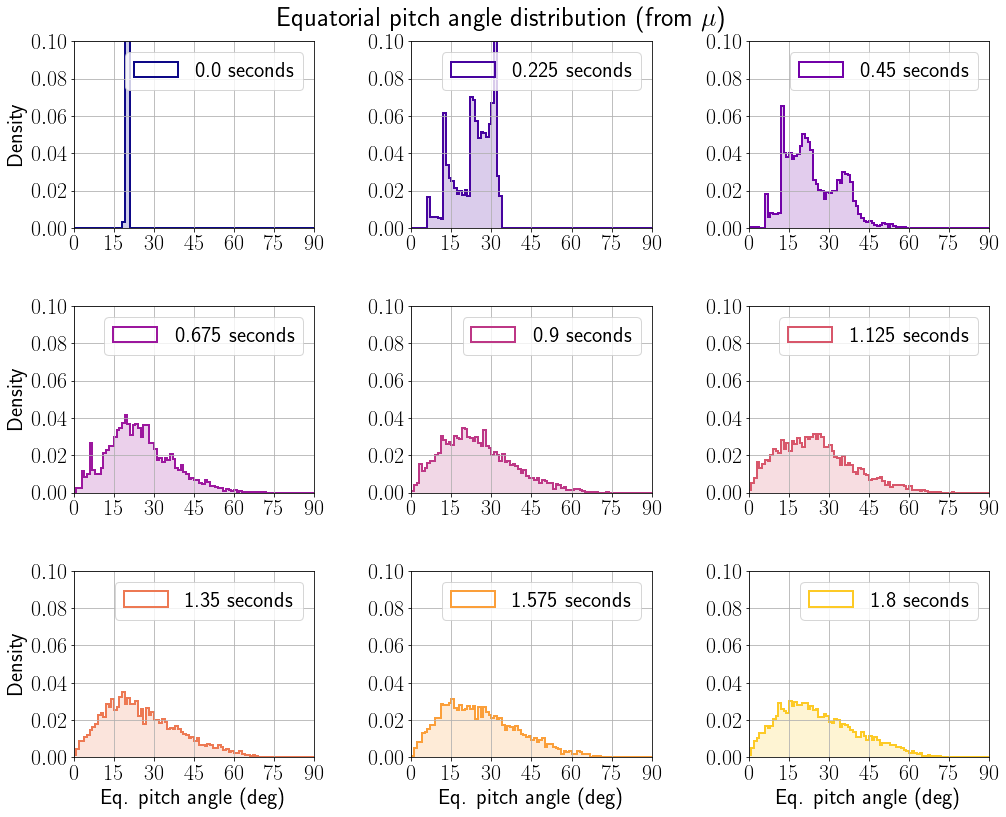

In [86]:
times = np.linspace(0, 1.8, 9)
colors = plt.cm.plasma([k / len(times) for k in range(len(times))])

fig = plt.figure(figsize=(15, 12))

for i, t in enumerate(times):
    plt.subplot(3, 3, i + 1)
    plt.hist(eq_pas_instantaneous[:, int(t / 1e-3)], bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'{t} seconds')
    plt.hist(eq_pas_instantaneous[:, int(t / 1e-3)], bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    plt.grid()
    plt.xlim([0, 90])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.yticks(np.arange(0, 0.11, 0.02))
    plt.xticks(np.arange(0, 91, 15))
    
    if i % 3 == 0:
        plt.ylabel('Density')
    
    if i > 5:
        plt.xlabel('Eq. pitch angle (deg)')

fig.suptitle('Equatorial pitch angle distribution (from $\mu$)')
plt.tight_layout(pad=2)
plt.show()

In [6]:
@njit
def per_particle_diffusion(history, delta_t, dt):
    num_particles    = len(history[:, 0, 0, 0])
    delta_t_ind      = int(delta_t / dt)
    steps            = int(len(history[0, :, 0, 0]) / delta_t_ind)
    v                = velocity(history)
    v_par, v_par_mag = velocity_par(history)
    indices          = np.arange(0, steps) * dt

    mus   = np.zeros((num_particles, steps - 1))
    D_uus = np.zeros((num_particles, steps - 1))

    for i in range(num_particles):
        for j in range(steps - 1):
            mu_begin    = v_par_mag[i, j * delta_t_ind] / np.linalg.norm(v[i, j * delta_t_ind])
            mu_end      = v_par_mag[i, (j + 1) * delta_t_ind] / np.linalg.norm(v[i, (j + 1) * delta_t_ind])
            D_uus[i, j] = (mu_end - mu_begin)**2 / (2 * delta_t)
            mus[i, j]   = mu_begin
            
    return mus, D_uus

@njit
def per_particle_eq_diffusion(history, ics, delta_t, dt):
    num_particles    = len(history[:, 0, 0, 0])
    delta_t_ind      = int(delta_t / dt)
    steps            = int(len(history[0, :, 0, 0]) / delta_t_ind)
    pas              = eq_pitch_angle_from_moment(history, ics[:, 4, 0:2])
    indices          = np.arange(0, steps) * dt

    mus   = np.zeros((num_particles, steps - 1))
    D_uus = np.zeros((num_particles, steps - 1))

    for i in range(num_particles):
        for j in range(steps - 1):
            #mu_begin    = v_par_mag[i, j * delta_t_ind] / np.linalg.norm(v[i, j * delta_t_ind])
            #mu_end      = v_par_mag[i, (j + 1) * delta_t_ind] / np.linalg.norm(v[i, (j + 1) * delta_t_ind])
            pa_begin    = pas[i, j * delta_t_ind]
            pa_end      = pas[i, (j + 1) * delta_t_ind]
            D_uus[i, j] = (pa_end - pa_begin)**2 / (2 * delta_t)
            mus[i, j]   = pa_begin
            
    return mus, D_uus

In [7]:
def average_over_mus(mus, D_uus, i, bins=20):
    D_uu_averaged = [[] for k in range(bins)]
    k = 1.0 / bins
    
    for j in range(len(mus[:, i])):
        bin_ind = floor(mus[j, i] // k)
        D_uu_averaged[bin_ind].append(D_uus[j, i])
        
    for i, d in enumerate(D_uu_averaged):
        if len(d) == 0:
            D_uu_averaged[i].append(0)
            
    D_uu_final = np.array([np.mean(k) for k in D_uu_averaged])
    return D_uu_final

In [144]:
def pa_evolution(history, h_bins, v_bins, T):
    pas = pitch_angle(history)
    pas_map = np.zeros((v_bins, h_bins))

    h_max = len(pas[0, :])

    for i, t in enumerate(np.linspace(0, h_max - 1, num=h_bins, endpoint=False)):
        t_ind = floor(t)
        pas_at_t = pas[:, t_ind]
        pas_map[:, i] = np.flip(np.histogram(pas_at_t, bins=np.linspace(0, 180, num=v_bins + 1), density=True)[0])
        
    fig = plt.figure(figsize=(10 * (h_bins / v_bins), 10)) 
    cax = plt.gca()
    
    im = cax.imshow(pas_map, cmap='plasma', norm=color.LogNorm(vmin=1e-4, vmax=1))
    
    plt.yticks(np.linspace(0, v_bins, 10), [f'{k:.2f}' for k in np.linspace(180, 0, 10)])
    plt.xticks(np.linspace(0, h_bins, 10), [f'{k:.2f}' for k in np.linspace(0, T, 10)])
    
    plt.ylabel('Pitch angle (deg)')
    plt.xlabel('Time (s)')
    plt.title('Evolution of pitch angle distribution')
    
    plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04, norm=color.PowerNorm(gamma=0.3))
    plt.show()

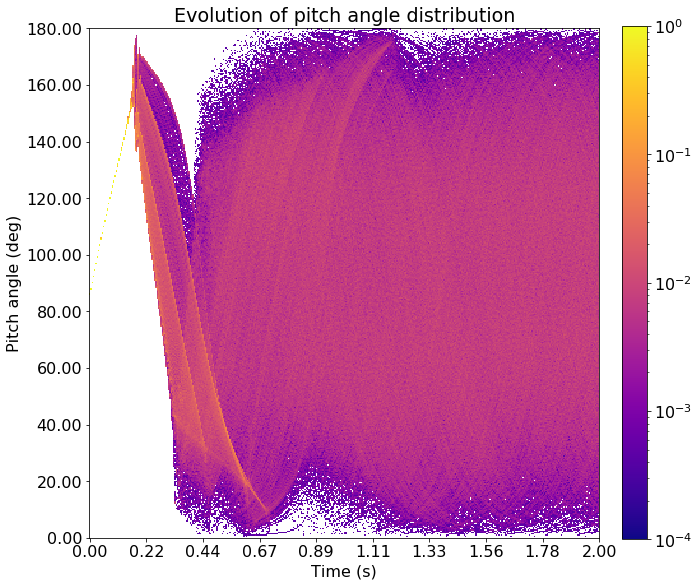

In [145]:
pa_evolution(system.history, 400, 400, 2)

In [142]:
def clamped_pa_evolution(history, h_bins, v_bins, T):
    pas = pitch_angle(history)
    pas_map = np.zeros((v_bins, h_bins))
    
    for i in range(len(pas[:, 0])):
        for j in range(len(pas[0, :])):
            p = pas[i, j]
            
            if p <= 90:
                continue
            else:
                pas[i, j] = 180 - p

    h_max = len(pas[0, :])

    for i, t in enumerate(np.linspace(0, h_max - 1, num=h_bins, endpoint=False)):
        t_ind = floor(t)
        pas_at_t = pas[:, t_ind]
        pas_map[:, i] = np.flip(np.histogram(pas_at_t, bins=np.linspace(0, 90, num=v_bins + 1), density=True)[0])
        
    fig = plt.figure(figsize=(10 * (h_bins / v_bins), 10)) 
    cax = plt.gca()
    
    im = cax.imshow(pas_map, cmap='plasma', norm=color.LogNorm(vmin=1e-4, vmax=1))
    
    plt.yticks(np.linspace(0, v_bins, 10), [f'{k:.2f}' for k in np.linspace(90, 0, 10)])
    plt.xticks(np.linspace(0, h_bins, 10), [f'{k:.2f}' for k in np.linspace(0, T, 10)])
    
    plt.ylabel('Pitch angle (deg)')
    plt.xlabel('Time (s)')
    plt.title('Evolution of pitch angle distribution')
    
    plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04)
    plt.show()

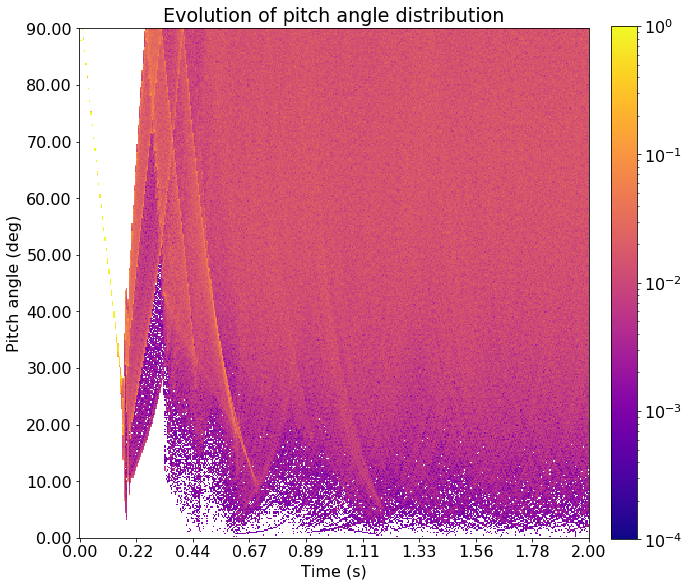

In [143]:
clamped_pa_evolution(system.history, 400, 400, 2)

In [146]:
def eq_pa_evolution(history, ics, h_bins, v_bins, T):
    pas = eq_pitch_angle_from_moment(history, ics[:, 4, 0:2])
    pas_map = np.zeros((v_bins, h_bins))

    h_max = len(pas[0, :])

    for i, t in enumerate(np.linspace(0, h_max - 1, num=h_bins, endpoint=False)):
        t_ind = floor(t)
        pas_at_t = pas[:, t_ind]
        pas_map[:, i] = np.flip(np.histogram(pas_at_t, bins=np.linspace(0, 90, num=v_bins + 1), density=True)[0])
        
    fig = plt.figure(figsize=(10 * (h_bins / v_bins), 10)) 
    cax = plt.gca()
    
    im = cax.imshow(pas_map, cmap='plasma', norm=color.LogNorm(vmin=1e-4, vmax=1))
    
    plt.yticks(np.linspace(0, v_bins, 10), [f'{k:.2f}' for k in np.linspace(90, 0, 10)])
    plt.xticks(np.linspace(0, h_bins, 10), [f'{k:.2f}' for k in np.linspace(0, T, 10)])
    
    plt.ylabel('Pitch angle (deg)')
    plt.xlabel('Time (s)')
    plt.title('Evolution of equatorial pitch angle distribution')
    
    plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04)
    plt.show()

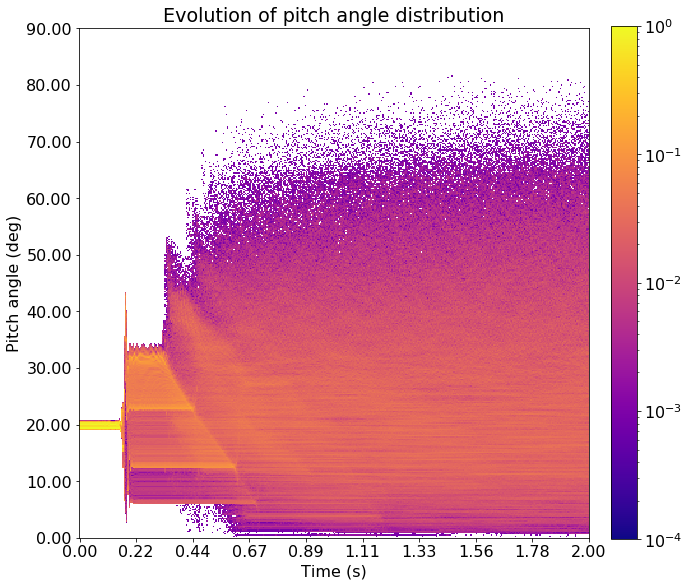

In [147]:
eq_pa_evolution(system.history, system.ics, 400, 400, 2)

In [13]:
def D_uu_evolution(history, h_bins, v_bins, T, dt):
    delta_t = T / h_bins
    mus, D_uus = per_particle_diffusion(history, delta_t, 1e-3)

    D_uu_map = np.zeros((v_bins, h_bins))
    h_max = len(D_uus[0, :])

    for i in range(h_max):
        D_uu_averaged = [[] for k in range(v_bins)]
        k = 1.0 / v_bins

        for j in range(len(mus[:, i])):
            bin_ind = floor(mus[j, i] // k)
            D_uu_averaged[bin_ind].append(D_uus[j, i])

        for k, d in enumerate(D_uu_averaged):
            if len(d) == 0:
                D_uu_averaged[k].append(0)
 
        D_uu_map[:, i] = np.flip(np.array([np.mean(k) for k in D_uu_averaged]))

    fig = plt.figure(figsize=(10 * (h_bins / v_bins), 10)) 
    cax = plt.gca()
    
    im = cax.imshow(D_uu_map, cmap='plasma')
    
    plt.yticks(np.linspace(0, v_bins, 10), [f'{k:.2f}' for k in np.linspace(90, 0, 10)])
    plt.xticks(np.linspace(0, h_bins, 10), [f'{k:.2f}' for k in np.linspace(0, T, 10)])
    
    plt.ylabel('Pitch angle (deg)')
    plt.xlabel('Time (s)')
    plt.title(r'Evolution of $D_{\mu\mu}(\mu)$')
    
    plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04)
    plt.show()

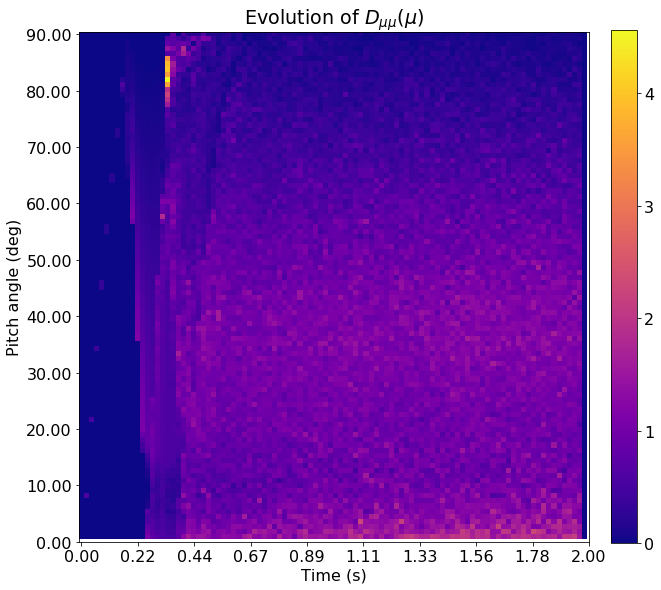

In [14]:
D_uu_evolution(system.history, 100, 100, 2.0, 1e-3)

In [15]:
def D_aa_evolution(history, ics, h_bins, v_bins, T, dt):
    delta_t = T / h_bins
    mus, D_uus = per_particle_eq_diffusion(history, ics, delta_t, 1e-3)

    D_uu_map = np.zeros((v_bins, h_bins))
    h_max = len(D_uus[0, :])

    for i in range(h_max):
        D_uu_averaged = [[] for k in range(v_bins)]
        k = 90.0 / v_bins

        for j in range(len(mus[:, i])):
            bin_ind = floor(mus[j, i] // k)
            D_uu_averaged[bin_ind].append(D_uus[j, i])

        for k, d in enumerate(D_uu_averaged):
            if len(d) == 0:
                D_uu_averaged[k].append(0)
 
        D_uu_map[:, i] = np.flip(np.array([np.mean(k) for k in D_uu_averaged]))

    fig = plt.figure(figsize=(10 * (h_bins / v_bins), 10)) 
    cax = plt.gca()
    
    im = cax.imshow(D_uu_map, cmap='plasma')
    
    plt.yticks(np.linspace(0, v_bins, 10), [f'{k:.2f}' for k in np.linspace(90, 0, 10)])
    plt.xticks(np.linspace(0, h_bins, 10), [f'{k:.2f}' for k in np.linspace(0, T, 10)])
    
    plt.ylabel('Pitch angle (deg)')
    plt.xlabel('Time (s)')
    plt.title(r'Evolution of $D_{\alpha_0\alpha_0}(\alpha_0)$')
    
    plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04)
    plt.show()

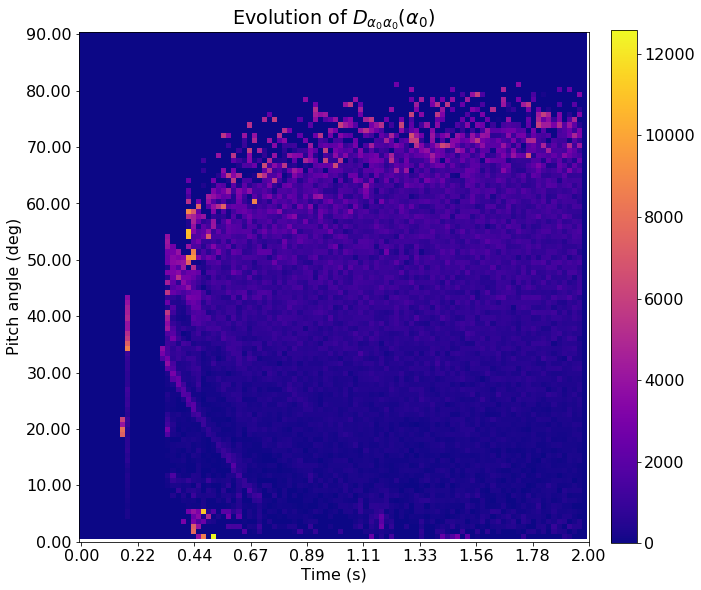

In [16]:
D_aa_evolution(system.history, system.ics, 100, 100, 2.0, 1e-3)

In [165]:
delta_t = 0.15
mus, D_uus = per_particle_diffusion(system.history, delta_t, 1e-3)

D_uu_map = np.zeros((v_bins, h_bins))
h_max = len(D_uus[0, :])

for i in range(h_max):
    D_uu_averaged = [[] for k in range(v_bins)]
    k = 1.0 / v_bins

    for j in range(len(mus[:, i])):
        bin_ind = floor(mus[j, i] // k)
        D_uu_averaged[bin_ind].append(D_uus[j, i])

    for k, d in enumerate(D_uu_averaged):
        if len(d) == 0:
            D_uu_averaged[k].append(0)

    D_uu_map[:, i] = np.flip(np.array([np.mean(k) for k in D_uu_averaged]))


In [22]:
def get_pas_at_bounce_phase_test(pas, particles, crossings, phase):
    bounce_pas = np.zeros(len(pas[:, 0])) - 1
    
    nth_crossing = int(phase // np.pi)
    additional_phase = phase % np.pi

    for i in range(len(particles)):
        zero_crossings = np.where(particles == i)[0]
        max_crossings = len(zero_crossings) - 1
        
        if max_crossings >= nth_crossing + 1:
            diff = crossings[zero_crossings][nth_crossing + 1] - crossings[zero_crossings][nth_crossing]
            eq_point = np.abs(pas[i, crossings[zero_crossings][nth_crossing]:crossings[zero_crossings][nth_crossing + 1]] - 90).argmax()
            first_half = eq_point
            second_half = diff - eq_point

            if additional_phase <= np.pi / 2:
                ind = int(first_half / (np.pi / 2) * additional_phase) + crossings[zero_crossings][nth_crossing]
                bounce_pas[i] = pas[i, ind]
            else:
                ind = int(first_half + second_half / (np.pi / 2) * (additional_phase - np.pi / 2)) + crossings[zero_crossings][nth_crossing]
                bounce_pas[i] = pas[i, ind]
    
    return bounce_pas[bounce_pas != -1]

In [73]:
pas = pitch_angle(system.history)
particles, crossings = np.where(np.diff(np.sign(pas - 90)))

In [74]:
def diff_over_bounce_phase(pas, particles, crossings, phase):
    mus = np.zeros(len(pas[:, 0])) - 1.0
    D_uus = np.zeros(len(pas[:, 0])) - 1.0
    
    nth_crossing = int(phase // np.pi)
    additional_phase = phase % np.pi

    for i in range(len(particles)):
        zero_crossings = np.where(particles == i)[0]
        max_crossings = len(zero_crossings) - 1
        
        if max_crossings >= nth_crossing + 2:
            pa_endpoints = np.array([0.0, 0.0])
            ind_endpoints = np.array([0.0, 0.0])
            
            for j in range(2):
                diff = crossings[zero_crossings][nth_crossing + j + 1] - crossings[zero_crossings][nth_crossing + j]
                eq_point = np.abs(pas[i, crossings[zero_crossings][nth_crossing + j]:crossings[zero_crossings][nth_crossing + j + 1]] - 90).argmax()
                first_half = eq_point
                second_half = diff - eq_point

                if additional_phase <= np.pi / 2:
                    ind = int(first_half / (np.pi / 2) * additional_phase) + crossings[zero_crossings][nth_crossing + j]
                    pa_endpoints[j] = pas[i, ind]
                    ind_endpoints[j] = ind
                else:
                    ind = int(first_half + second_half / (np.pi / 2) * (additional_phase - np.pi / 2)) + crossings[zero_crossings][nth_crossing + j]
                    pa_endpoints[j] = pas[i, ind]
                    ind_endpoints[j] = ind
                    
            mus[i] = pa_endpoints[0]
            D_uus[i] = (pa_endpoints[1] - pa_endpoints[0])**2 / (2 * (ind_endpoints[1] - ind_endpoints[0]) * 1e-3)
    
    return mus, D_uus

In [96]:
mus, D_uus = diff_over_bounce_phase(pas, particles, crossings, np.radians(0))

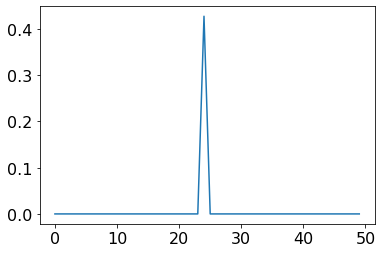

In [97]:
bins = 50

D_uu_averaged = [[] for k in range(bins)]
k = 180.0 / bins

for j in range(len(mus)):
    bin_ind = floor(mus[j] // k)
    D_uu_averaged[bin_ind].append(D_uus[j])

for k, d in enumerate(D_uu_averaged):
    if len(d) == 0:
        D_uu_averaged[k].append(0)

plt.plot([np.mean(k) for k in D_uu_averaged])
plt.show()

In [58]:
particles = len(system.history[:, 0, 0, 0])
steps     = len(system.history[0, :, 0, 0])
eps       = 0.5 * Re

#for s in range(steps):
#    inds = np.where(np.abs(system.history[:, s, 0, 2]) <= eps)[0]
#    print(pas[inds])
    
def pa_eq_plane_evolution(history, h_bins, v_bins, T, folded=False):
    pas = pitch_angle(history)
    pas_map = np.zeros((v_bins, h_bins))
    
    if folded:
        for i in range(len(pas[:, 0])):
            for j in range(len(pas[0, :])):
                p = pas[i, j]

                if p <= 90:
                    continue
                else:
                    pas[i, j] = 180 - p
    
    eps = 0.1 * Re
    h_max = len(pas[0, :])
    
    degs = 180
    if folded:
        degs = 90

    for i, t in enumerate(np.linspace(0, h_max - 1, num=h_bins, endpoint=False)):
        t_ind = floor(t)
        p_inds = np.where(np.abs(history[:, t_ind, 0, 2]) <= eps)[0]
        pas_at_t = pas[p_inds, t_ind]
        pas_map[:, i] = np.flip(np.histogram(pas_at_t, bins=np.linspace(0, degs, num=v_bins + 1), density=True)[0])
        
        if np.isnan(pas_map[:, i]).all():
            pas_map[:, i] = np.zeros(v_bins)
        
    fig = plt.figure(figsize=(10 * (h_bins / v_bins), 10)) 
    cax = plt.gca()
    
    im = cax.imshow(pas_map, cmap='plasma')
    
    plt.yticks(np.linspace(0, v_bins, 10), [f'{k:.2f}' for k in np.linspace(degs, 0, 10)])
    plt.xticks(np.linspace(0, h_bins, 10), [f'{k:.2f}' for k in np.linspace(0, T, 10)])
    
    plt.ylabel('Pitch angle (deg)')
    plt.xlabel('Time (s)')
    plt.title('Evolution of equatorial pitch angle distribution')
    
    plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04, norm=color.PowerNorm(gamma=0.3))
    plt.show()

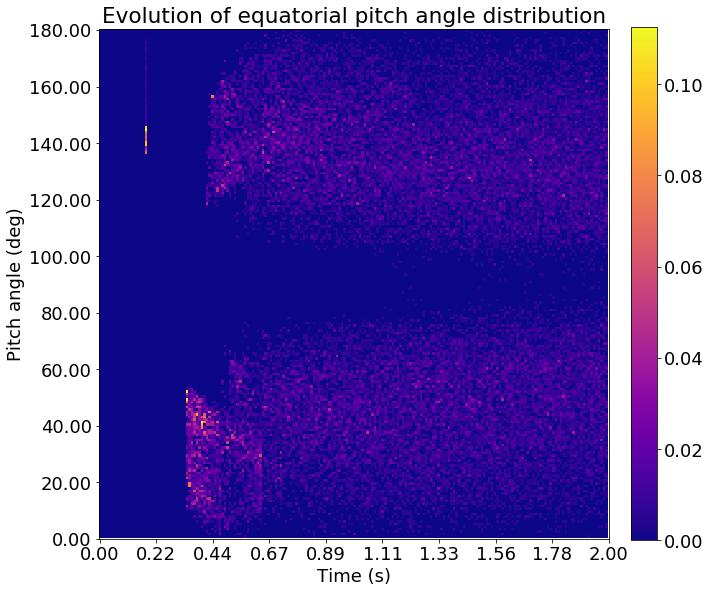

In [64]:
pa_eq_plane_evolution(system.history, 200, 200, 2, False)

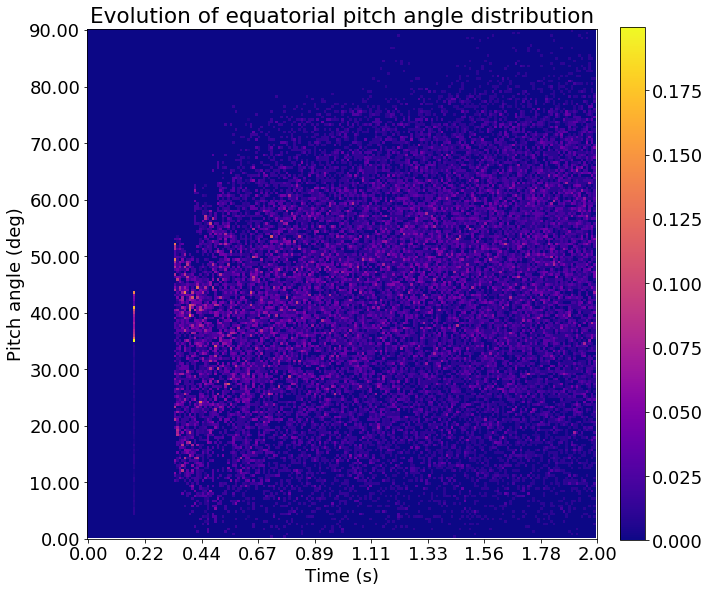

In [65]:
pa_eq_plane_evolution(system.history, 200, 200, 2, True)